In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col

from utils import make_precinct_counts,make_demo_map,job_cols,race_cols,cols_to_keep,scale_and_cluster,make_edname,map_round_votes

from shapely import wkt

from stargazer.stargazer import Stargazer

demo_cluster = pd.read_csv('../../chapter_two/data/occupation_demo_clusters_on_ed.csv')
d38 = pd.read_csv('../../cc_election_cleaning/all_rounds_results/district_38.csv')
ed_level = pd.read_csv('../../cc_election_cleaning/occupation_demo_data_feb21.csv')

ed_shapefile = '../../chapter_two/data/nyed_21a/nyed.shp'
ed_gdf = gpd.read_file(ed_shapefile)

full_results = pd.read_csv('../../cc_election_cleaning/election_results_with_vote_sponsor_cluster_FEB13.csv')
aa = full_results[full_results['candidate'] == 'Alexa Aviles']

In [2]:
import seaborn as sns
from sklearn.decomposition import FactorAnalysis
from sklearn.decomposition import PCA
from factor_analyzer import calculate_kmo, calculate_bartlett_sphericity

In [3]:
ae = pd.read_csv('../../cc_election_cleaning/ae_precincts.csv')
av = pd.read_csv('../../cc_election_cleaning/additional_variables.csv')
fwe = pd.read_csv('../data/finance_with_ethnicity.csv')
f_plus = pd.read_csv('../../council_campaign_finance/data/iwrl_plus.csv')
occ_df = pd.read_csv('../../cc_election_cleaning/occupation_election_feb21.csv')

In [4]:
p_cols = [col for col in occ_df.columns if col[-1] == 'p']
wp_cols = [col for col in occ_df.columns if col.startswith("w2") and col.endswith("p")]
wp_cols.remove('w2cop')
to_remove = [ 'w2psp',
 'w2sep',
 'w2npp',
 'w2govp',
 'w2nip']
wp_cols = [col for col in wp_cols if col not in to_remove]
demo_cols = ['nhw21p','nhb21p','h21p','nha21p','cvap21bapp','mhhi21']

In [5]:
demo_occ = aa[['vote_share','ed_name','nhw21p','nhb21p','h21p','nha21p','cvap21bapp','mhhi21','venez21p','chin21p',
                 'kor21p','colomb21p','domin21p','mex21p','white_transplant_ratio']].merge(occ_df, left_on='ed_name', right_on='ElectDist', how='left')

In [6]:
demo_occ = demo_occ.merge(ae[['ElectDist','ind21p','bang21p','pak21p','filip21p']],on = 'ElectDist',how='left')
demo_occ = demo_occ.merge(av,on='ElectDist',how='left')

In [5]:
d38 = make_edname(d38)

In [6]:
d38_eds = d38['ed_name'].unique().tolist()

In [7]:
def make_demo_map(eds_list,demo_df):
    demo_map = demo_df[demo_df['ElectDist'].isin(eds_list)]
    demo_map['geometry'] = demo_map['geometry'].apply(wkt.loads)
    demo_map = gpd.GeoDataFrame(demo_map)
    return demo_map

C:\Users\samtg\AppData\Local\Temp\ipykernel_17204\2425529744.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demo_map['geometry'] = demo_map['geometry'].apply(wkt.loads)


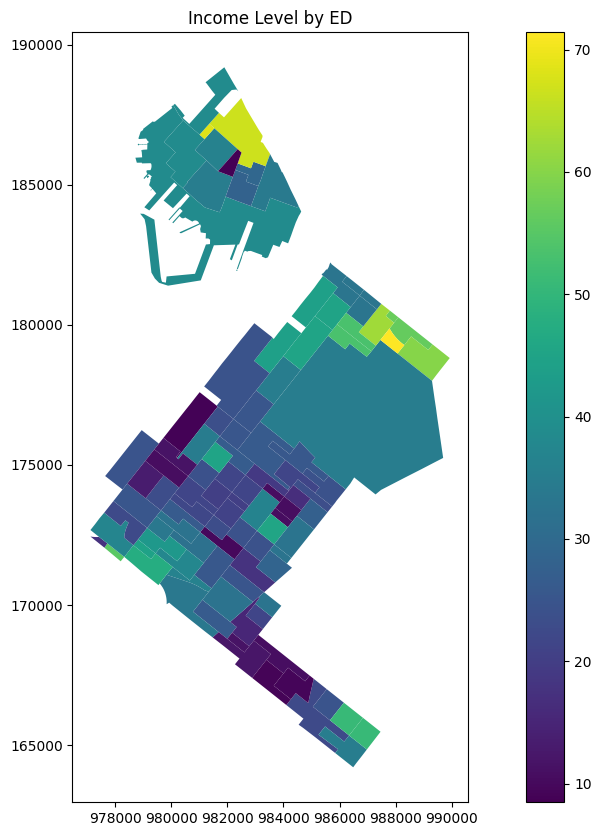

In [8]:
demo_map = make_demo_map(d38_eds,ed_level)
#demo_map = demo_map[demo_map['mhhi21'] < 299999]
demo_map.plot(column='nhw21p', cmap='viridis', legend=True, figsize=(15, 10))
plt.title("Income Level by ED")
plt.show()

In [41]:
demo_map[['ElectDist','mhhi21']].sort_values('mhhi21',ascending=False).head(10)

,ElectDist,mhhi21
2145,51010,572289.285195
2146,51011,351763.525011
2200,51072,344661.616517
1965,49001,286041.499556
1978,49015,265856.141249
5766,51052,256983.359140
5503,49008,242637.969367
2161,51027,236597.967452
2023,49061,228784.974301
2187,51058,214655.822054


In [9]:
full_results_thirty_eight = full_results[full_results['district'] == 38]
frte_winner = full_results_thirty_eight[full_results_thirty_eight['winner'] == True]

In [9]:
full_results_thirty_eight.groupby('candidate')['vote'].sum().sort_values(ascending=False)

candidate
Alexa Aviles           4599.0
Yu Lin                 3025.0
Rodrigo G. Camarena    1345.0
Jacqui Painter         1142.0
Cesar Zuniga           1035.0
Victor Swinton          471.0
219518.0                196.0
221151.0                 77.0
221286.0                 46.0
218123.0                 41.0
217777.0                 38.0
overvote                 34.0
Write-in                 32.0
221291.0                 10.0
Name: vote, dtype: float64

In [14]:
d38[d38['district_38_choice_1'] == 'Yu Lin'].groupby('district_38_choice_1')['district_38_choice_2'].value_counts().reset_index(name='count').sort_values('count', ascending=False).head(10)


,district_38_choice_1,district_38_choice_2,count
0,Yu Lin,Alexa Aviles,295
1,Yu Lin,Cesar Zuniga,256
2,Yu Lin,Victor Swinton,179
3,Yu Lin,Jacqui Painter,152
4,Yu Lin,Rodrigo G. Camarena,136
5,Yu Lin,Yu Lin,76
6,Yu Lin,Write-in,7
7,Yu Lin,overvote,3


In [18]:
d38[d38['district_38_choice_1'] == 'Rodrigo G. Camarena'] \
    .groupby('district_38_choice_1')['district_38_choice_2'] \
    .value_counts(dropna=False) \
    .reset_index(name='count') \
    .sort_values('count', ascending=False) \
    .head(10)

,district_38_choice_1,district_38_choice_2,count
0,Rodrigo G. Camarena,Alexa Aviles,589
1,Rodrigo G. Camarena,NaN,292
2,Rodrigo G. Camarena,Cesar Zuniga,227
3,Rodrigo G. Camarena,Jacqui Painter,163
4,Rodrigo G. Camarena,Yu Lin,55
5,Rodrigo G. Camarena,Victor Swinton,50
6,Rodrigo G. Camarena,Rodrigo G. Camarena,12
7,Rodrigo G. Camarena,Write-in,2
8,Rodrigo G. Camarena,overvote,1


In [19]:
frte_winner['candidate'].value_counts() 

candidate
Alexa Aviles           52
Yu Lin                 39
Jacqui Painter          8
Rodrigo G. Camarena     2
Cesar Zuniga            2
Name: count, dtype: int64

In [48]:
frte_winner = frte_winner[['ed_name', 'candidate','geometry']]

In [50]:
frte_winner['geometry'] = frte_winner['geometry'].apply(wkt.loads)
frte_winner = gpd.GeoDataFrame(frte_winner)

In [52]:
frte_winner['candidate'] = frte_winner['candidate'].astype('category')

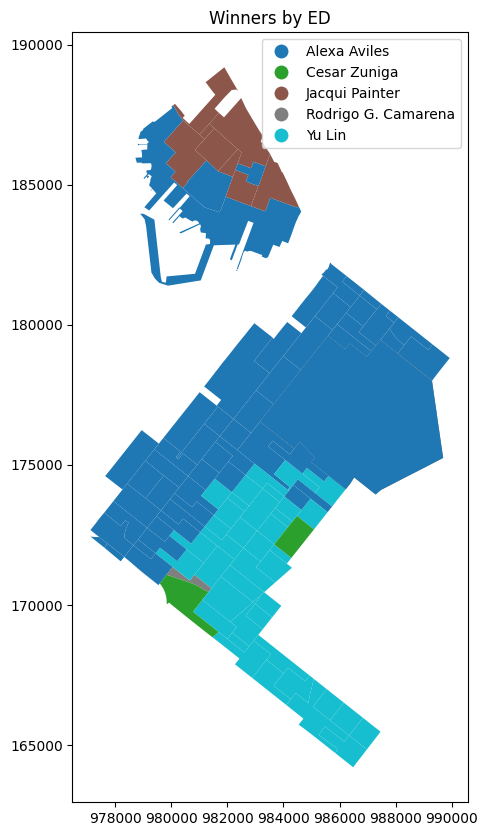

In [53]:
frte_winner.plot(column='candidate', cmap='tab10', legend=True, figsize=(15, 10))
plt.title("Winners by ED")
plt.show()

Correlations and EFA

In [ ]:
['w2scip','w2mgtp','w2lawp','h21p','white_transplant_ratio','w2admp','cvap21bapp','domin21p',
 'chin21p','nha21p','w2hsp','w2foodp','w2psp','p21fb']

In [42]:
cor_cols = demo_occ.drop(columns=['ElectDist','ed_name','geometry_x','geometry_y']).columns.tolist()
cor_matrix = demo_occ[cor_cols].corr()
cor_matrix.dropna(subset=('vote_share'),inplace=True)
cor_matrix.sort_values(by='chin21p', ascending=False)
cor_matrix[['chin21p','w2scip']].sort_values(by='chin21p', ascending=False).head(6)

,chin21p,w2scip
chin21p,1.000000,-0.483227
nha21p,0.992725,-0.469449
w2hsp,0.752771,-0.495061
djt24p,0.716003,-0.613899
w2foodp,0.695372,-0.534026
p21fb,0.639081,-0.475759


In [16]:
demo_occ['log_mhhi21'] = np.log(demo_occ['mhhi21'])

In [84]:
test_cols = ['nhw21p','nhb21p','h21p','nha21p','cvap21bapp','log_mhhi21','venez21p','chin21p','kor21p','colomb21p','domin21p',
'mex21p','white_transplant_ratio','ind21p','bang21p','pak21p','filip21p','greek21p','arab21p',
'fb21bdp','fb21drp','hh21bop'] + wp_cols

In [26]:
label_map = {
    'nhw21p': 'NH White',
    'nhb21p': 'NH Black',
    'h21p': 'Hispanic',
    'nha21p': 'NH Asian',
    'cvap21bapp': 'BA+',
    'log_mhhi21': 'Log Median Household Income',
    'mex21p': 'Mexican',
    'white_transplant_ratio': 'White Transplant Ratio',
    'w2admp':'Arists, Deisigners, and Journalists',
    'w2scip': 'Science/Research Professionals',
    'vote_share': 'Aviles Vote Share',}

In [27]:
small_cor_cols = ['vote_share','h21p','nhw21p','nha21p','white_transplant_ratio','mex21p','cvap21bapp','log_mhhi21','w2admp','w2scip']
small_cor_matrix = demo_occ[small_cor_cols].corr()
small_cor_matrix.dropna(subset=('vote_share'),inplace=True) 
small_cor_matrix.rename(index=label_map, columns=label_map, inplace=True)

In [85]:
kmo_all, kmo_model = calculate_kmo(demo_occ[test_cols])
chi_square_value, p_value = calculate_bartlett_sphericity(demo_occ[test_cols])

print("KMO per item:", kmo_all)
print("Overall KMO:", kmo_model)       
print("Bartlett’s test χ²:", chi_square_value, "p-value:", p_value) 

KMO per item: [0.50786587 0.19610602 0.47963572 0.39726147 0.58809346 0.56912817
 0.30048599 0.40415596 0.41829342 0.14792323 0.34027009 0.31304945
 0.66362148 0.1628203  0.25867733 0.16534268 0.31546678 0.45568157
 0.23628836 0.17333777 0.54323209 0.10600743 0.51678463 0.70932468
 0.25657022 0.4715406  0.55729849 0.27860774 0.34411024 0.53946217
 0.52355985 0.44088239 0.18772961 0.55747767 0.14117169 0.23801797
 0.60753754 0.40958455 0.27904442 0.43398848 0.29615092 0.20662477
 0.43220022 0.26983444 0.42059359 0.39974315 0.32829824]
Overall KMO: 0.38584261601297
Bartlett’s test χ²: 5800.226827670139 p-value: 0.0


In [60]:
def iterative_kmo_prune(df, threshold_item=0.50, threshold_overall=0.60):
    from factor_analyzer import calculate_kmo
    df_current = df.copy()
    while True:
        kmo_items, kmo_overall = calculate_kmo(df_current)
        worst_idx = kmo_items.argmin()
        if (kmo_overall >= threshold_overall and 
            all(kmo_items >= threshold_item)):
            break
        drop_var = df_current.columns[worst_idx]
        print(f"Dropping '{drop_var}' (KMO={kmo_items[worst_idx]:.3f}); new overall KMO before recalculation = {kmo_overall:.3f}")
        df_current = df_current.drop(columns=[drop_var])
    return df_current

In [86]:
pruned_df = iterative_kmo_prune(demo_occ[test_cols])

Dropping 'hh21bop' (KMO=0.106); new overall KMO before recalculation = 0.386
Dropping 'w2ffp' (KMO=0.122); new overall KMO before recalculation = 0.424
Dropping 'w2htp' (KMO=0.134); new overall KMO before recalculation = 0.454
Dropping 'filip21p' (KMO=0.137); new overall KMO before recalculation = 0.484
Dropping 'arab21p' (KMO=0.161); new overall KMO before recalculation = 0.528
Dropping 'colomb21p' (KMO=0.255); new overall KMO before recalculation = 0.538
Dropping 'pak21p' (KMO=0.280); new overall KMO before recalculation = 0.552
Dropping 'w2oadp' (KMO=0.294); new overall KMO before recalculation = 0.582
Dropping 'w2emrp' (KMO=0.322); new overall KMO before recalculation = 0.603
Dropping 'fb21bdp' (KMO=0.338); new overall KMO before recalculation = 0.609
Dropping 'bang21p' (KMO=0.162); new overall KMO before recalculation = 0.611
Dropping 'nhb21p' (KMO=0.373); new overall KMO before recalculation = 0.639
Dropping 'w2matp' (KMO=0.343); new overall KMO before recalculation = 0.643
Dropp

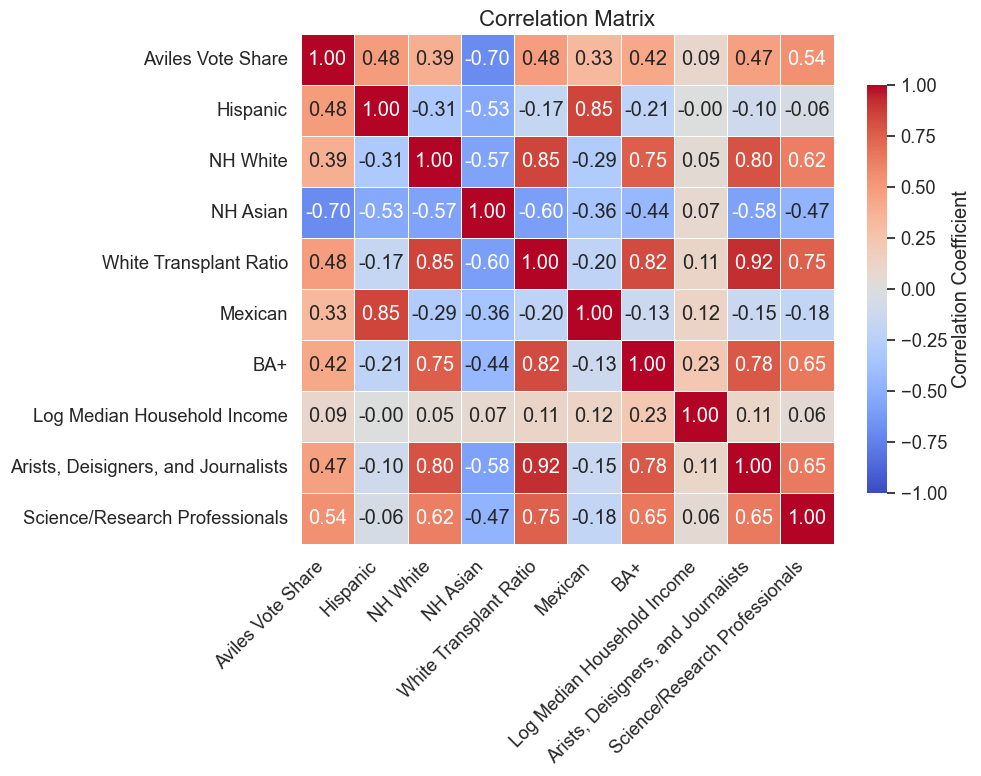

In [28]:
plt.figure(figsize=(10, 8))
sns.set(style="white", font_scale=1.2)

heatmap = sns.heatmap(
    small_cor_matrix,
    annot=True,             
    fmt=".2f",             
    cmap="coolwarm",        
    vmin=-1, vmax=1,        
    linewidths=0.5,         
    cbar_kws={"shrink": 0.8, 'label': 'Correlation Coefficient'}
)

plt.title("Correlation Matrix", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [87]:
predictors = pruned_df.columns.tolist()

X = demo_occ[predictors]

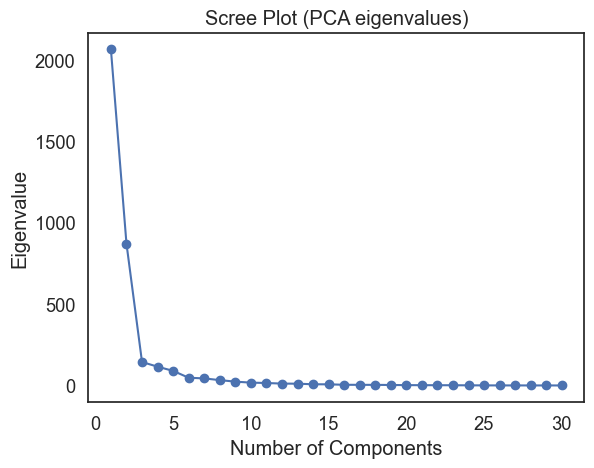

In [ ]:
pca = PCA()
pca.fit(X)

ev = pca.explained_variance_

plt.plot(range(1, len(ev) + 1), ev, marker='o')
plt.title('Scree Plot (PCA eigenvalues)')
plt.xlabel('Number of Components')
plt.ylabel('Eigenvalue')
plt.show()

In [97]:
n_factors = 6
fa = FactorAnalysis(n_components=n_factors, random_state=0)
factor_scores = fa.fit_transform(X)

In [98]:
fa_df = pd.DataFrame(
    factor_scores,
    columns=[f'Factor{i+1}' for i in range(n_factors)],
    index=demo_occ.index
)

In [99]:
loadings = pd.DataFrame(
    fa.components_.T,
    index=predictors,
    columns=fa_df.columns
)
print("Factor Loadings:\n", loadings)

Factor Loadings:
                           Factor1    Factor2   Factor3   Factor4   Factor5  \
nhw21p                  -9.198074  16.583353 -1.937671  1.624428 -2.363976   
h21p                   -13.476562 -15.296551  1.554377  0.686505 -0.411282   
nha21p                  25.916228  -3.885205  1.850490  0.503444 -0.323547   
cvap21bapp              -5.937973  10.244701  0.054624  4.179102 -8.313543   
venez21p                -0.135267  -0.024988  0.071324  0.140098  0.159835   
chin21p                 25.119594  -4.225378  2.151092  0.786704 -0.277500   
kor21p                  -0.047089   0.080592 -0.016265  0.057542 -0.093227   
domin21p                -1.950349  -2.461236  1.022236 -0.271766  0.417373   
mex21p                  -5.518791  -8.250157  0.072399  0.276913 -2.040233   
white_transplant_ratio  -4.667491   6.288558 -1.387237  3.142806 -2.597275   
greek21p                -0.038237   0.194434 -0.018942  0.036148 -0.046820   
fb21drp                 -1.368670  -1.893046  

In [100]:
Y = demo_occ['vote_share']
model_fa = sm.OLS(Y, sm.add_constant(fa_df)).fit()
print(model_fa.summary())

                            OLS Regression Results                            
Dep. Variable:             vote_share   R-squared:                       0.647
Model:                            OLS   Adj. R-squared:                  0.624
Method:                 Least Squares   F-statistic:                     27.82
Date:                Wed, 04 Jun 2025   Prob (F-statistic):           1.23e-18
Time:                        15:22:48   Log-Likelihood:                -371.68
No. Observations:                  98   AIC:                             757.4
Df Residuals:                      91   BIC:                             775.4
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         35.1938      1.126     31.269      0.0